# Using Autoencoders on Fashion MNIST

Goal: train an autoencoder on the fashion MNIST dataset



>[Using Autoencoders on Fashion MNIST](#scrollTo=f8274188-2c1b-447a-a40c-fbd92df2bf88)

>>[Libraries and Packages](#scrollTo=FhaS4pkbSB0X)

>>>[Helper functions](#scrollTo=z_FQqCcsPBAU)

>>[Parameters](#scrollTo=Fg6yU9R2ApFC)

>>[Prepare Dataset](#scrollTo=eLZJxSTxBEjL)

>>[Build the autoencoder](#scrollTo=2YzJ8uJ-DBKP)

>>>[Encoder](#scrollTo=_dJozQynFQOr)

>>>[Decoder](#scrollTo=s8hrn3y3FSiJ)

>>[Joining the Encoder and Decoder (Autoencoder)](#scrollTo=ZhGcb3WhHIez)

>>[Training the autoencoder](#scrollTo=RywyOO_VHef6)

>>[Reconstruct using the autoencoder](#scrollTo=jWBQTbqQLmKM)

>>[Embed using the encoder](#scrollTo=DCYm0F67MCc9)

>>[Generate using the decoder](#scrollTo=8bnSSwXkM1qa)

>[Experiment: Add more layers to Encoder and Decoder](#scrollTo=SnDjwtUYRKFY)

>>>[Encoder 2 w/ additional Conv2d layer](#scrollTo=ft68lKm3SUXa)

>>>[Decoder 2 w/ additional Conv2dTranspose layer](#scrollTo=JyAjaKbuShcL)

>>>[Joining the new encoder and decoder into an Autoencoder](#scrollTo=ct6GekkwTth6)

>>[Training the new autoencoder](#scrollTo=pR1K6rtNUKkl)

>>[Reconstruct Autoencoder](#scrollTo=Yjr5Y-bTVJn3)

>>[Embed using the encoder](#scrollTo=VsgqGUHsUdcQ)

>>[Generate using the new autoencoder](#scrollTo=yZa9hkFvVvqH)



## Libraries and Packages

In [ ]:
# Libraries and packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

### Helper functions

In [ ]:
# To exract single batch from a Tensorflow dataset
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

# To display a set of images in a grid format
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## Parameters

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1 #Gray Channel
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2 #.8 train, .2 validation
EMBEDDING_DIM = 2
EPOCHS = 3

## Prepare Dataset

Info on the Fashion MNIST dataset:
https://www.kaggle.com/datasets/zalando-research/fashionmnist. The dataset comes prepackaged in TensorFlow which we will retrieve on the code below:

In [ ]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Images are 28x28 greyscale with pixel values 0-255. We need to preprocess the images to ensure that the pixel values are scaled between 0 and 1. We will also pad the image to 32 for easier tensor manipulation. (Note that we defined this under "[Parameters](#scrollTo=Fg6yU9R2ApFC)" ie `IMAGE_SIZE = 32`)

In [ ]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

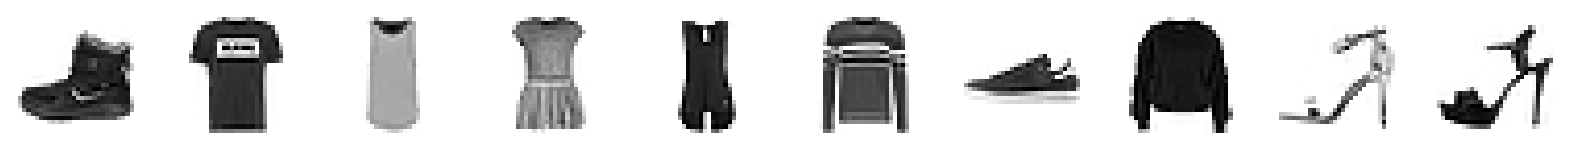

In [ ]:
# Show some items of clothing from the training set
display(x_train)

## Build the autoencoder

- An *encoder* compresses high dimensional input data (like an image) into a lower-dimensional embedding vector.
- A *decoder* decompresses a given embedding vector back to the original domain (image).

<center><img src = "https://miro.medium.com/v2/resize:fit:640/format:webp/0*83pAHsVsnsqySOHN.png">

[Source](https://medium.com/@soumallya160/the-basic-concept-of-autoencoder-the-self-supervised-deep-learning-454e75d93a04)</center>

### Encoder

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
# First convolution layer
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
# 2nd convolution layer
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# 3rd convolution layer
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

# Flatten layers
x = layers.Flatten()(x)

# Dense output
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

### Decoder
This is a mirror image of the encoder but instead of using `Conv2D` we use `Conv2DTranspose`. Setting `strides=2` doubles the size of the input tensor in both dimensions.

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Dense input
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

# first Conv2DTranspose layer
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# second Conv2DTranspose layer
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# third Conv2DTranspose layer
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Output
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

## Joining the Encoder and Decoder (Autoencoder)

In [ ]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## Training the autoencoder

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2897

600/600 [==============================] - 309s 511ms/step - loss: 0.2897 - val_loss: 0.2623
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2570

600/600 [==============================] - 294s 489ms/step - loss: 0.2570 - val_loss: 0.2571
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2540

600/600 [==============================] - 288s 480ms/step - loss: 0.2540 - val_loss: 0.2546


In [ ]:
# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## Reconstruct using the autoencoder

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 9s 54ms/step
Example real clothing items


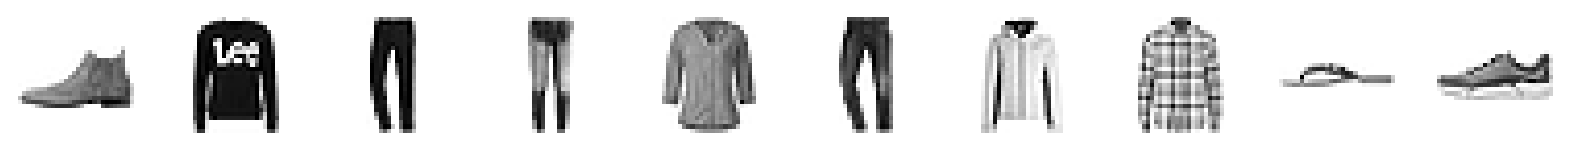

Reconstructions


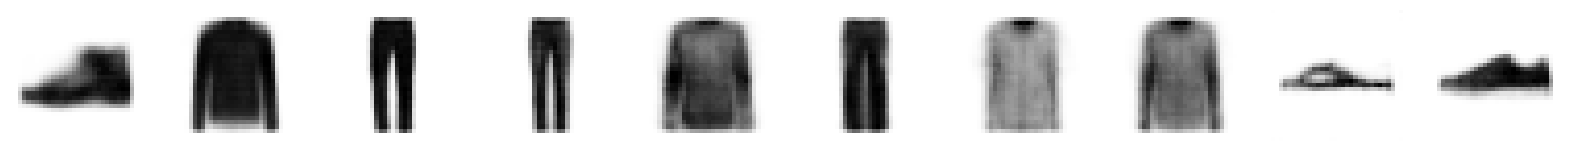

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## Embed using the encoder

In [ ]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 2s 12ms/step


In [ ]:
# Some examples of the embeddings
print(embeddings[:10])

[[-1.3303452   2.1410625 ]
 [-5.939987   -2.4362311 ]
 [ 1.3721591  -5.9240937 ]
 [ 1.2714213  -3.5628905 ]
 [-3.466582   -0.77362746]
 [ 0.15765144 -4.6847396 ]
 [-1.6150256  -1.1721275 ]
 [-2.7188668  -1.0959619 ]
 [ 0.78261524  2.7592542 ]
 [-0.41567278  3.9071085 ]]


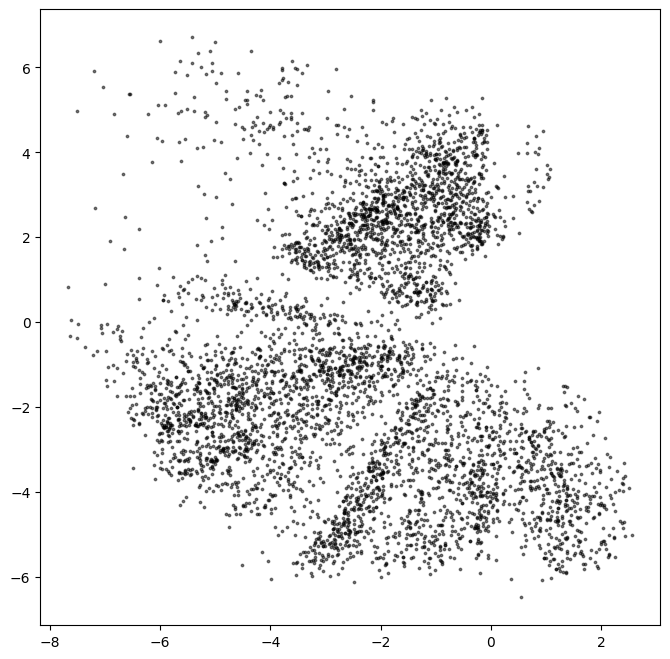

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

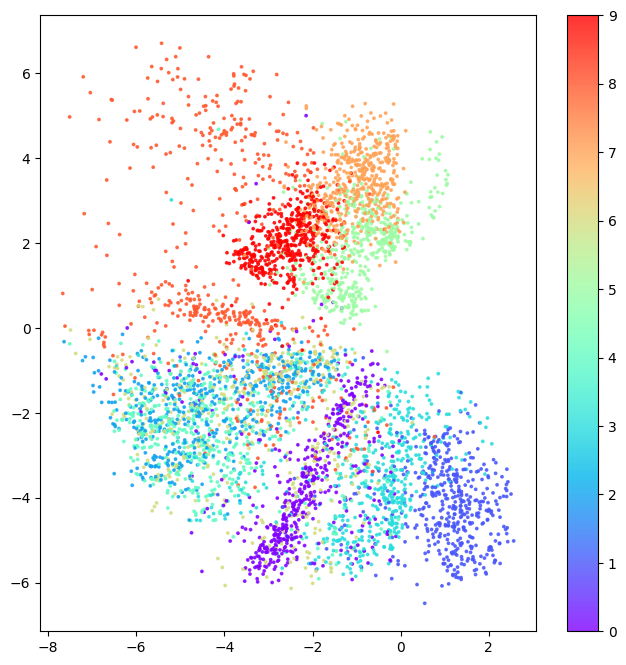

In [ ]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

ID and Clothing Label

0 - T-shirt/top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandal

6 - Shirt

7 - Sneaker

9 - Bag

9 - Ankle boot


## Generate using the decoder

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 371ms/step


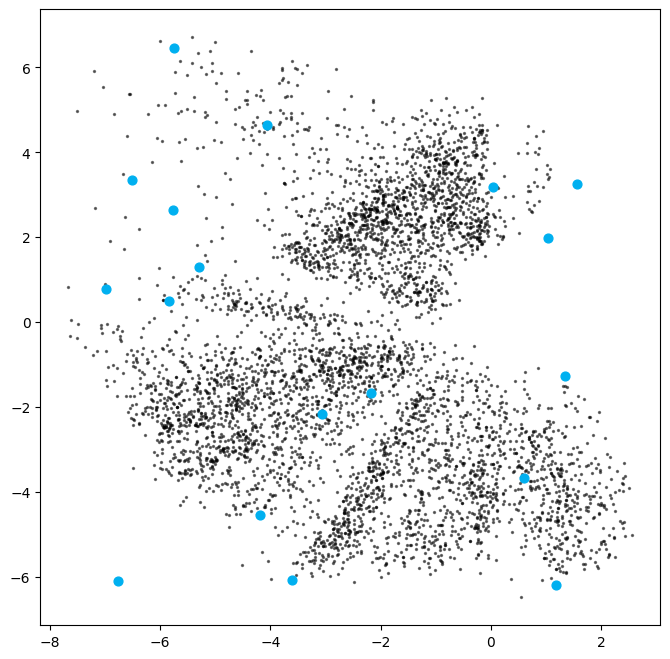

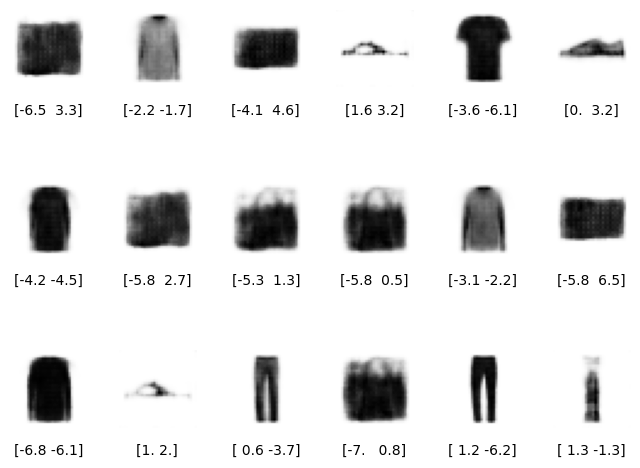

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 1s 72ms/step


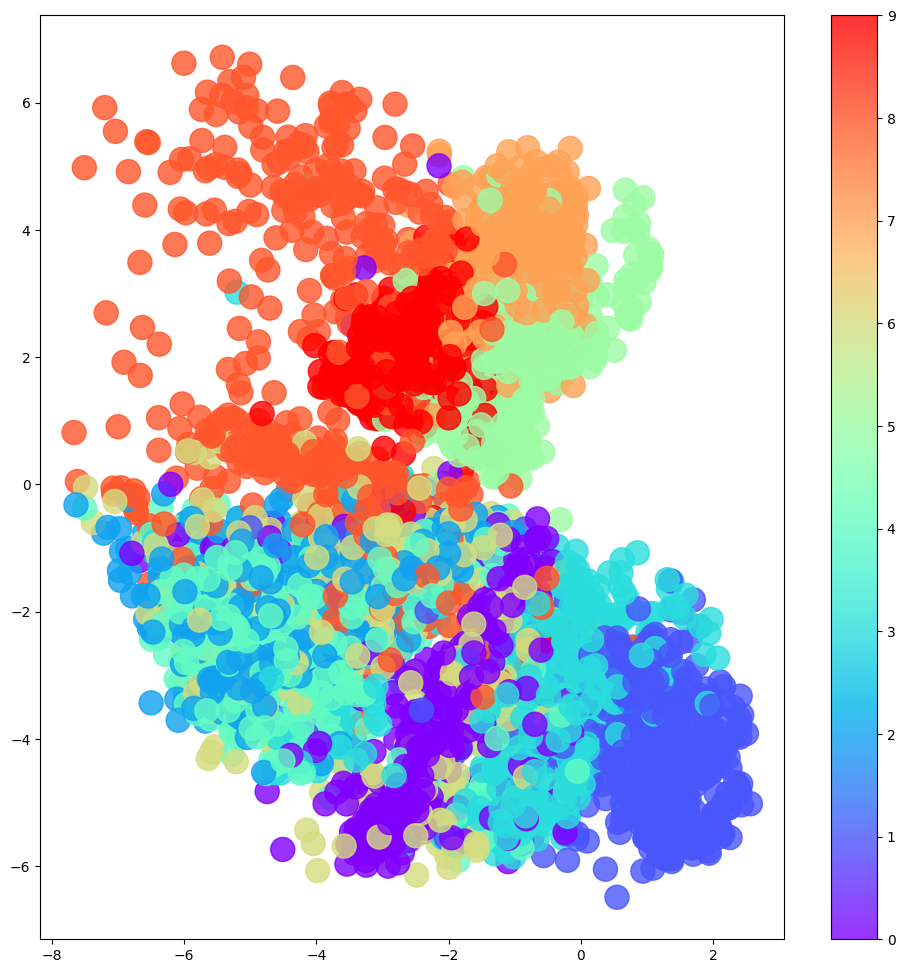

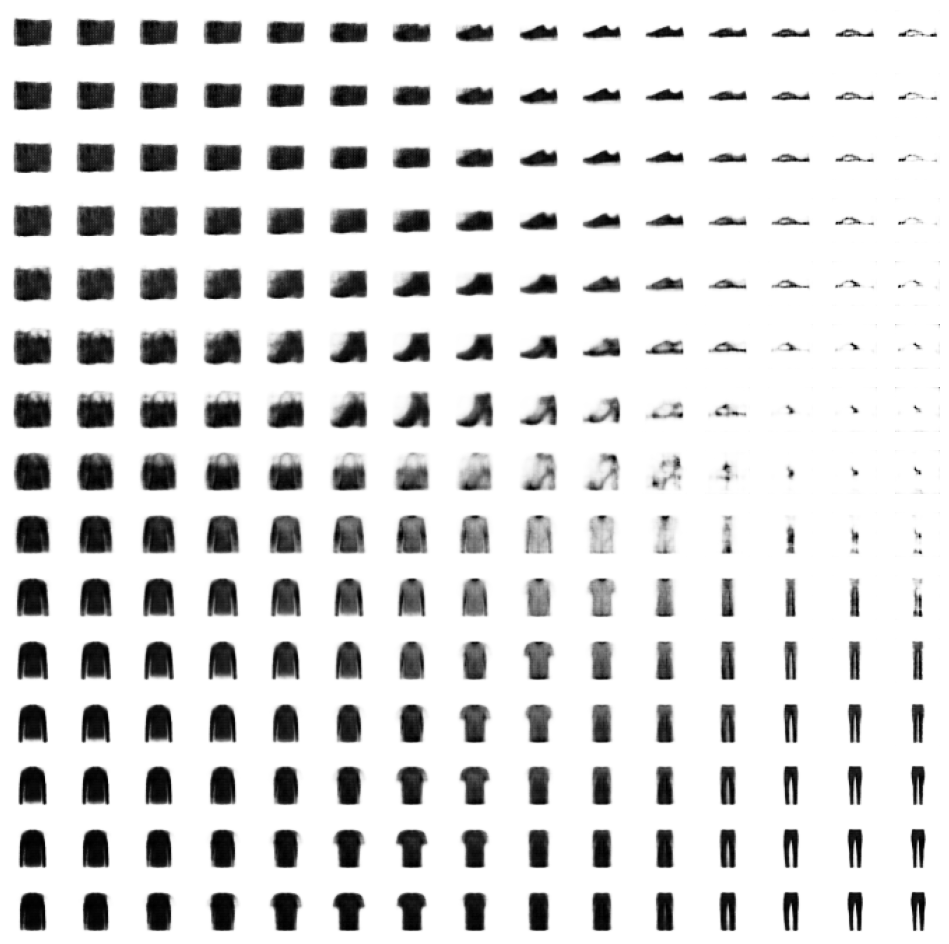

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

----

# Experiment: Add more layers to Encoder and Decoder


### Encoder 2 w/ additional Conv2d layer

In [ ]:
# Encoder2
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
# First convolution layer
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
# 2nd convolution layer
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# 3rd convolution layer
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# 4th convolution layer
x = layers.Conv2D(256, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

# Flatten layers
x = layers.Flatten()(x)

# Dense output
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder2 = models.Model(encoder_input, encoder_output)
encoder2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 2050  

### Decoder 2 w/ additional Conv2dTranspose layer

In [ ]:
# Decoder2
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Dense input
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

# new Conv2DTranspose layer
x = layers.Conv2DTranspose(
    256, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# first Conv2DTranspose layer
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# second Conv2DTranspose layer
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# third Conv2DTranspose layer
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

# Output
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder2 = models.Model(decoder_input, decoder_output)
decoder2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1024)              3072      
                                                                 
 reshape (Reshape)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 64)       7379

### Joining the new encoder and decoder into an Autoencoder

In [ ]:
# Autoencoder
autoencoder2 = models.Model(
    encoder_input, decoder2(encoder_output)
)  # decoder(encoder_output)
autoencoder2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 2050

## Training the new autoencoder

In [ ]:
# Compile the autoencoder
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
autoencoder2.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2911

600/600 [==============================] - 532s 882ms/step - loss: 0.2911 - val_loss: 0.2575
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2534

600/600 [==============================] - 535s 892ms/step - loss: 0.2534 - val_loss: 0.2526
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2500

600/600 [==============================] - 541s 901ms/step - loss: 0.2500 - val_loss: 0.2504


In [ ]:
# Save the final models
autoencoder2.save("./models/autoencoder2")
encoder2.save("./models/encoder2")
decoder2.save("./models/decoder2")

## Reconstruct Autoencoder

157/157 [==============================] - 21s 133ms/step
Example real clothing items


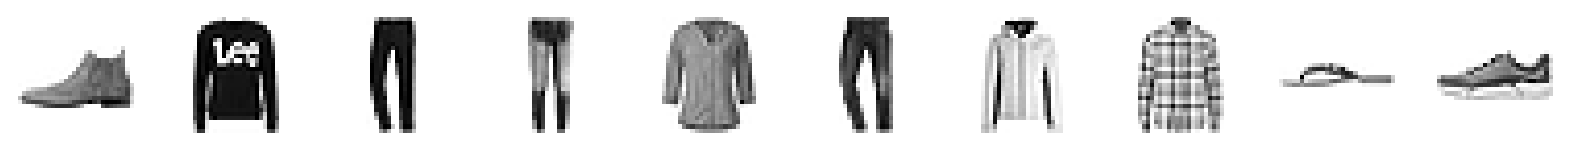

Reconstructions


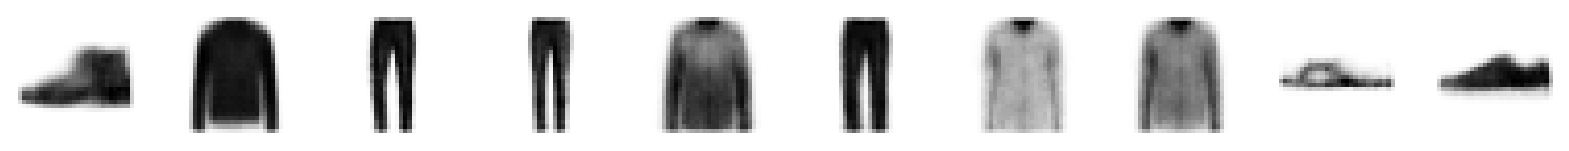

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions2 = autoencoder2.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions2)

## Embed using the encoder

In [ ]:
# Encode the example images
embeddings2 = encoder2.predict(example_images)

157/157 [==============================] - 3s 16ms/step


In [ ]:
# Some examples of the embeddings
print(embeddings2[:10])

[[  3.984674    -3.3160586 ]
 [ -0.46952438   0.04621655]
 [-12.573377     5.354203  ]
 [-14.806373     0.9863803 ]
 [ -0.7019521   -1.1700864 ]
 [ -6.4608736    2.74014   ]
 [ -1.678128    -2.5559132 ]
 [ -1.1727767   -1.5637103 ]
 [  3.2446709  -12.75955   ]
 [  3.1158977   -7.2672462 ]]


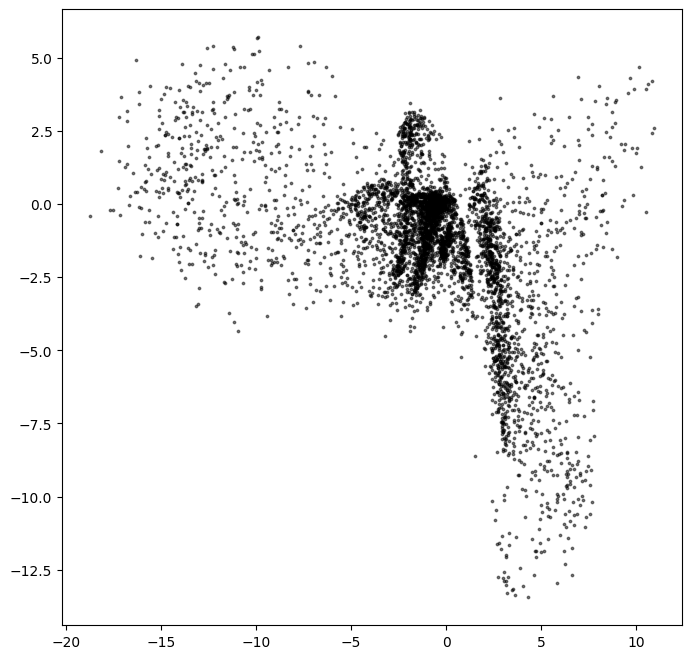

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings2[:, 0], embeddings2[:, 1], c="black", alpha=0.5, s=3)
plt.show()

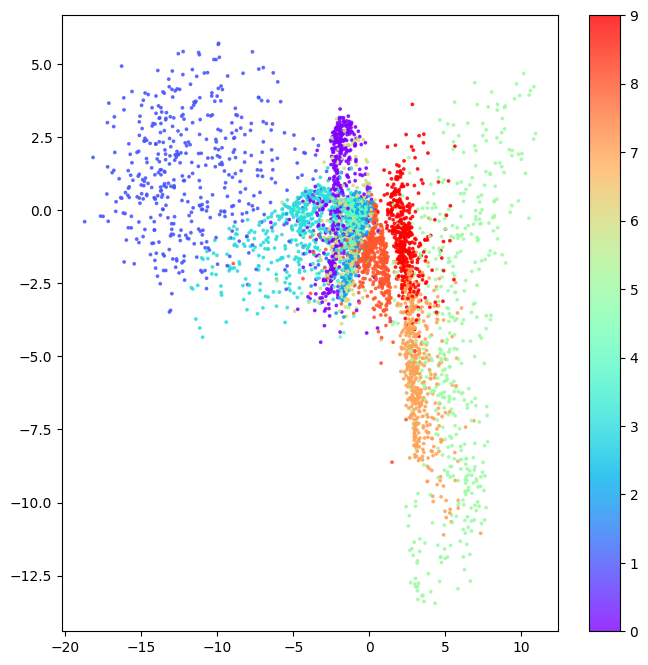

In [ ]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings2[:, 0],
    embeddings2[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

ID and Clothing Label

0 - T-shirt/top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandal

6 - Shirt

7 - Sneaker

9 - Bag

9 - Ankle boot


## Generate using the new autoencoder

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings2, axis=0), np.max(embeddings2, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Decode the sampled points
reconstructions2 = decoder2.predict(sample)

1/1 [==============================] - 0s 371ms/step


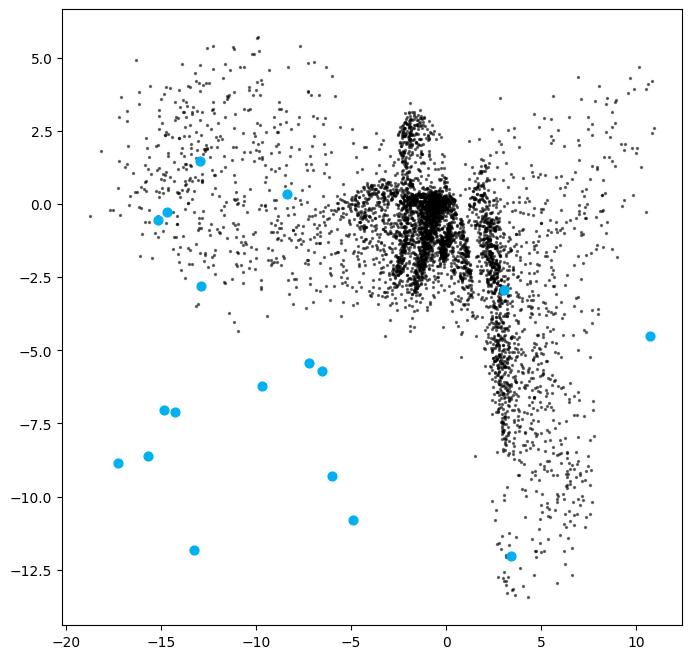

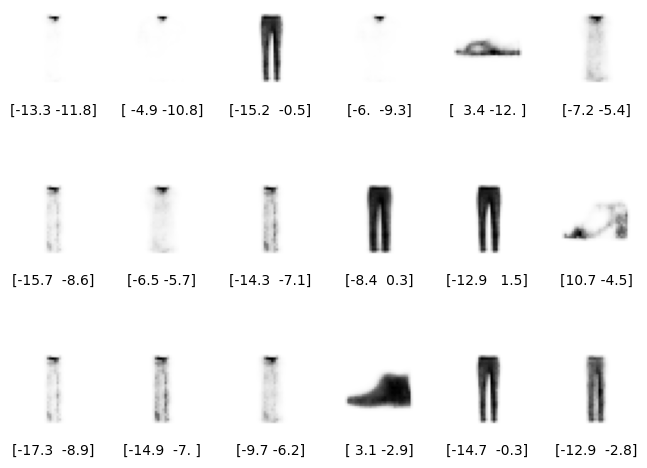

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings2[:, 0], embeddings2[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions2[i, :, :], cmap="Greys")

8/8 [==============================] - 1s 107ms/step


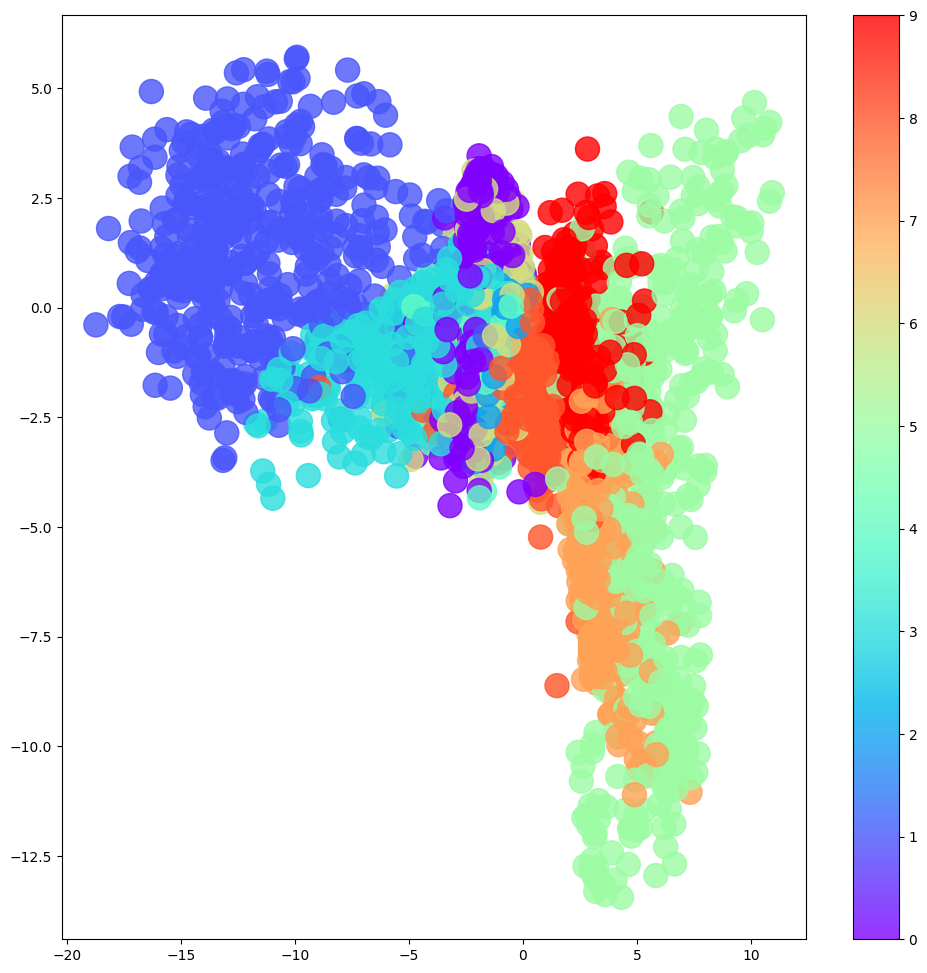

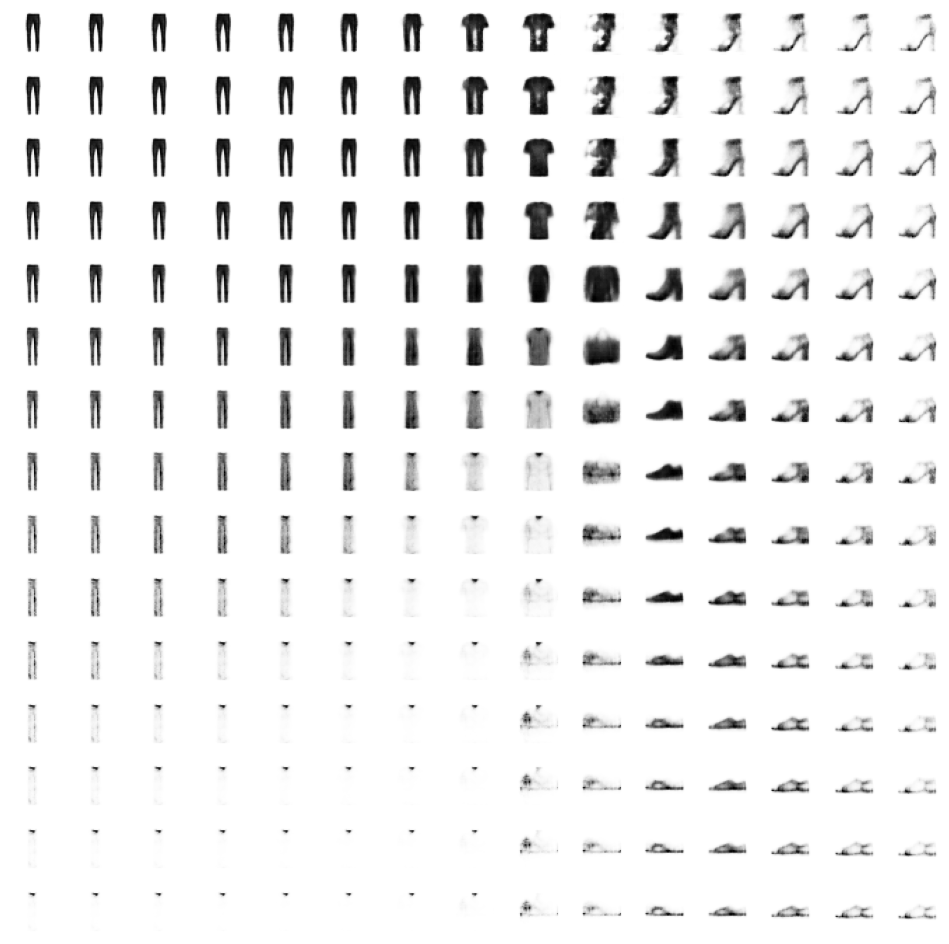

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings2[:, 0],
    embeddings2[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings2[:, 0]), max(embeddings2[:, 0]), grid_size)
y = np.linspace(max(embeddings2[:, 1]), min(embeddings2[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions2 = decoder2.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions2[i, :, :], cmap="Greys")

Observations:
- Loss: lower value on the autoencoder with added convolutional layers.
- Training time took longer than previous due to more trainable parameters.
- No visual improvement in reconstructed images from new autoencoder.
- Adding convolutional layers on both encoder and decoder overparameterized the model which may not be useful for the specific use-case.
